In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
# import optuna


pd.set_option('display.max_columns', None)

In [35]:
rfm_df = pd.read_excel('rfm_df.xlsx')
rfm_df

,Телефон_new,quarter,total_orders,unique_sku,avg_sku_per_order,avg_check,med_check,avg_sku_check,med_sku_check,mean_days_between_orders,median_days_between_orders,total_margin,newyear_flag,weekend_order_share,peak_month_ratio,defect_ratio,delivery_method,good_type,Geo,ДЕТСКОЕ ПИТАНИЕ,ЖЕНСКИЕ ШТУЧКИ,ИГРУШКИ,"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",КОСМЕТИКА/ГИГИЕНА,КРУПНОГАБАРИТНЫЙ ТОВАР,ОБУВЬ,ПОДГУЗНИКИ,СОПУТСТВУЮЩИЕ ТОВАРЫ,"ТЕКСТИЛЬ, ТРИКОТАЖ",ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА,ТОВАРЫ ДЛЯ ЖИВОТНЫХ,ТОВАРЫ ДЛЯ КОРМЛЕНИЯ,R_Score,F_Score,M_Score,RFM_Segment,segment_group,cluster_kmeans,cluster_gmm
0,55525753-50494856495470,2017Q2,1,2,1.00,4809.000000,4809.0,2404.500000,2404.5,0.0,0.0,600.00,0,0.0,0.0,0.500000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,2,312,Freshers,12,0
1,55525753-50535655495477,2017Q1,1,2,1.00,900.000000,900.0,300.000000,300.0,0.0,0.0,138.00,0,1.0,1.0,0.600000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,1,311,Freshers,5,5
2,55525753-53565350484974,2017Q1,2,3,1.00,2999.333333,3300.0,912.666667,1100.0,15.0,15.0,579.08,0,0.0,0.0,0.000000,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,1,2,2,122,At Churn Risk,5,5
3,55525753-54565357505774,2017Q2,1,3,1.00,3880.000000,3880.0,125.333333,122.0,0.0,0.0,444.55,0,0.0,0.0,0.400000,5,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,3,1,2,312,Freshers,12,4
4,55525753-55515454494872,2017Q3,1,6,1.00,3668.000000,3668.0,346.666667,199.5,0.0,0.0,628.40,0,0.0,0.0,0.538462,0,0,0,3,0,0,0,0,1,0,1,0,0,0,0,0,3,1,2,312,Freshers,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231695,57485355-52485257575698,2017Q1,1,1,1.00,2076.000000,2076.0,2076.000000,2076.0,0.0,0.0,238.00,0,0.0,0.0,0.000000,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,1,1,311,Freshers,5,5
231696,57495351-50535151545597,2017Q3,1,6,1.00,1827.000000,1827.0,523.000000,161.0,12.0,0.0,343.63,0,1.0,0.0,0.000000,1,0,0,0,0,2,0,1,0,0,0,0,0,0,2,0,2,1,2,212,Sleeping,0,0
231697,57505754-52565350494991,2017Q1,1,2,1.00,8303.000000,8303.0,4151.500000,4151.5,0.0,0.0,954.22,0,0.0,0.0,0.333333,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,1,3,313,Freshers,5,5
231698,57545549-57544957525799,2017Q2,1,1,1.00,2560.000000,2560.0,2560.000000,2560.0,0.0,0.0,294.00,0,1.0,0.0,0.909091,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,1,2,312,Freshers,1,0


In [36]:
segment_counts_per_quarter = rfm_df.groupby('quarter')['segment_group'].value_counts().unstack(fill_value=0)
segment_counts_per_quarter


segment_group,At Churn Risk,Drifting,Freshers,Lost,Loyal,Sleeping,VIP
quarter,,,,,,,
2017Q1,17246,2846,28611,3857,4592,4412,516
2017Q2,8761,8397,18781,14166,3623,13951,453
2017Q3,4833,6267,14366,17786,5569,15521,2213
2017Q4,786,2887,6897,10968,1843,8629,2923


In [37]:
# Short Preprocessing 

rfm_model_df = rfm_df[rfm_df['quarter'] != '2017Q1'].copy()
rfm_model_df = rfm_model_df.dropna(subset=['segment_group'])

In [38]:
le = LabelEncoder()
rfm_model_df['segment_encoded'] = le.fit_transform(rfm_model_df['segment_group'])


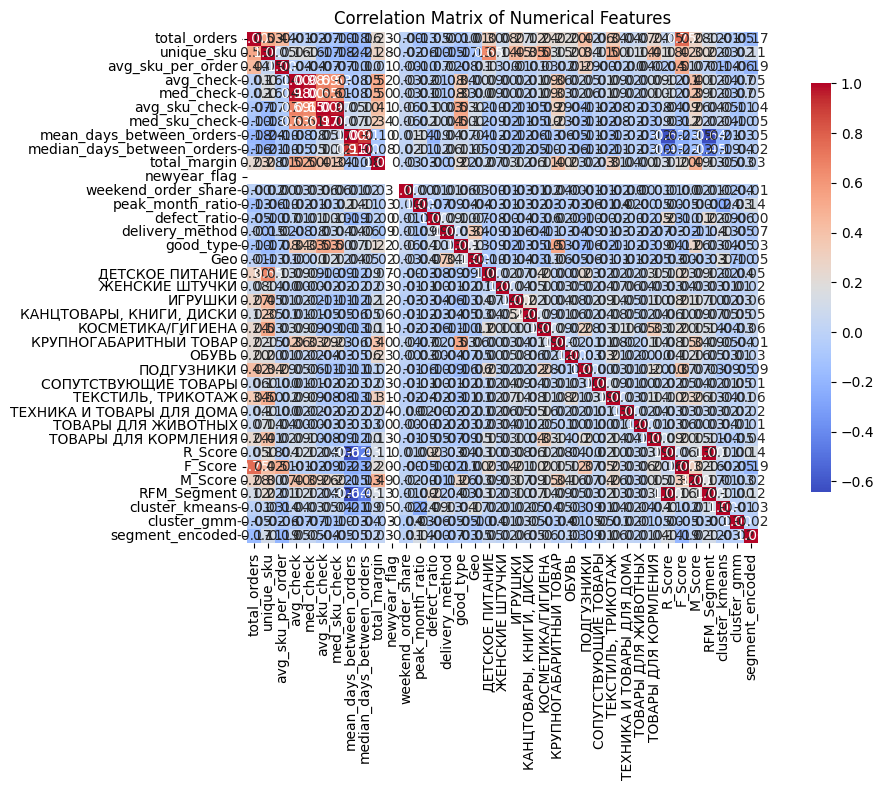

In [33]:
# Correlation Matrix
numeric_df = rfm_model_df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


In [39]:
drop_cols = ['Телефон_new', 'quarter', 
             'R_Score', 'F_Score', 'M_Score', 
             'RFM_Segment', 'segment_group', 
             'total_margin', 'total_orders'
            ]
feature_cols = [col for col in rfm_model_df.columns if col not in drop_cols + ['segment_encoded']]

X = rfm_model_df[feature_cols].select_dtypes(include=['number'])
y = rfm_model_df['segment_encoded']

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
# Distribution by classes in the train
train_distribution = pd.Series(y_train).value_counts(normalize=True).rename('train_share')
train_distribution

segment_encoded
3    0.253036
2    0.236079
5    0.224627
1    0.103474
0    0.084778
4    0.065057
6    0.032949
Name: train_share, dtype: float64

In [43]:
# Distribution by classes in the test
test_distribution = pd.Series(y_test).value_counts(normalize=True).rename('test_share')
test_distribution

segment_encoded
3    0.253036
2    0.236087
5    0.224620
1    0.103467
0    0.084778
4    0.065057
6    0.032956
Name: test_share, dtype: float64

--------

# Class Prediction

## LogisticRegression

In [44]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred_logreg, target_names=le.classes_))

               precision    recall  f1-score   support

At Churn Risk       0.75      0.84      0.79      2876
     Drifting       0.71      0.69      0.70      3510
     Freshers       0.89      0.92      0.91      8009
         Lost       0.94      0.92      0.93      8584
        Loyal       0.59      0.59      0.59      2207
     Sleeping       0.85      0.74      0.79      7620
          VIP       0.43      0.71      0.54      1118

     accuracy                           0.82     33924
    macro avg       0.74      0.77      0.75     33924
 weighted avg       0.83      0.82      0.82     33924



## KNeighborsClassifier

In [47]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

               precision    recall  f1-score   support

At Churn Risk       0.63      0.60      0.62      2876
     Drifting       0.55      0.57      0.56      3510
     Freshers       0.68      0.84      0.75      8009
         Lost       0.90      0.89      0.89      8584
        Loyal       0.37      0.26      0.30      2207
     Sleeping       0.53      0.50      0.52      7620
          VIP       0.47      0.21      0.29      1118

     accuracy                           0.67     33924
    macro avg       0.59      0.55      0.56     33924
 weighted avg       0.66      0.67      0.66     33924



## RandomForestClassifier

In [49]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [50]:
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

               precision    recall  f1-score   support

At Churn Risk       0.96      0.92      0.94      2876
     Drifting       0.89      0.82      0.85      3510
     Freshers       0.94      0.98      0.96      8009
         Lost       0.98      0.99      0.98      8584
        Loyal       0.78      0.78      0.78      2207
     Sleeping       0.92      0.94      0.93      7620
          VIP       0.80      0.66      0.72      1118

     accuracy                           0.93     33924
    macro avg       0.90      0.87      0.88     33924
 weighted avg       0.93      0.93      0.93     33924



## GradientBoostingClassifier

In [51]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [52]:
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))

               precision    recall  f1-score   support

At Churn Risk       0.94      0.88      0.91      2876
     Drifting       0.88      0.79      0.83      3510
     Freshers       0.93      0.98      0.95      8009
         Lost       0.96      0.99      0.97      8584
        Loyal       0.75      0.71      0.73      2207
     Sleeping       0.90      0.92      0.91      7620
          VIP       0.75      0.64      0.69      1118

     accuracy                           0.91     33924
    macro avg       0.87      0.84      0.86     33924
 weighted avg       0.91      0.91      0.91     33924



## CatBoostClassifier

In [53]:
catboost = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,
    auto_class_weights='Balanced'
)

catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred_catboost, target_names=le.classes_))

               precision    recall  f1-score   support

At Churn Risk       0.93      0.95      0.94      2876
     Drifting       0.83      0.90      0.86      3510
     Freshers       0.97      0.96      0.97      8009
         Lost       0.99      0.98      0.98      8584
        Loyal       0.78      0.79      0.79      2207
     Sleeping       0.96      0.89      0.93      7620
          VIP       0.68      0.84      0.75      1118

     accuracy                           0.93     33924
    macro avg       0.88      0.90      0.89     33924
 weighted avg       0.93      0.93      0.93     33924



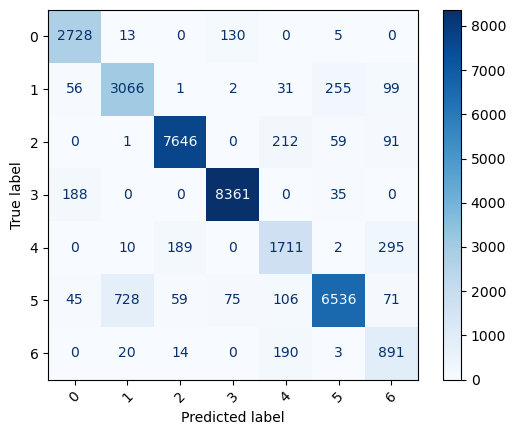

In [24]:
cm = confusion_matrix(y_test, y_pred_catboost, labels=catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')

-------

# Hyperparameter Selection (WIP)

## optuna

In [67]:
X = rfm_model_df[feature_cols].select_dtypes(include='number')
y = rfm_model_df['segment_encoded']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [68]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("random_strength", 0.1, 1.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "auto_class_weights": "Balanced",
        "random_seed": 42,
        "verbose": 0
    }

    model = CatBoostClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        early_stopping_rounds=30,
        verbose=0
    )
    
    preds = model.predict(X_test)
    return f1_score(y_test, preds, average="macro")

In [69]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-04-12 21:22:34,919] A new study created in memory with name: no-name-e24e0289-78a9-46cf-baac-953e979bae9c
[I 2025-04-12 21:22:36,397] Trial 0 finished with value: 0.07412172940413318 and parameters: {'iterations': 639, 'depth': 5, 'learning_rate': 0.024925774941377148, 'l2_leaf_reg': 9.382335992859286, 'random_strength': 0.281777663836365, 'bagging_temperature': 0.2515817084398445}. Best is trial 0 with value: 0.07412172940413318.
[I 2025-04-12 21:22:37,742] Trial 1 finished with value: 0.07534207991509186 and parameters: {'iterations': 617, 'depth': 5, 'learning_rate': 0.059460810486603934, 'l2_leaf_reg': 8.214742753198218, 'random_strength': 0.6688140372753885, 'bagging_temperature': 0.36357341765833906}. Best is trial 1 with value: 0.07534207991509186.
[I 2025-04-12 21:22:39,251] Trial 2 finished with value: 0.07412172940413318 and parameters: {'iterations': 393, 'depth': 6, 'learning_rate': 0.03585204194248389, 'l2_leaf_reg': 3.0243402798495937, 'random_strength': 0.4837690

In [70]:
# Best trial:
print(study.best_trial.params)

{'iterations': 201, 'depth': 8, 'learning_rate': 0.11128980702306884, 'l2_leaf_reg': 6.989932384743744, 'random_strength': 0.6610614349143911, 'bagging_temperature': 0.7546018806713117}


## GridSearchCV

In [76]:
catboost_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)

In [ ]:
param_grid = {
    'iterations': [300, 500],
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

In [79]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x30e1aaa90>,
             n_jobs=-1,
             param_grid={'depth': [6, 8], 'iterations': [300, 500],
                         'l2_leaf_reg': [3, 5, 7],
                         'learning_rate': [0.05, 0.1]},
             scoring='f1_macro')

In [80]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"\nBest macro F1-score: {grid_search.best_score_}")

Best parameters: {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

Best macro F1-score: 0.7766406859224254


In [88]:
best_model = grid_search.best_estimator_

In [94]:
y_pred = best_model.predict(X_test)

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2876
           1       0.00      0.00      0.00      3510
           2       0.27      0.99      0.43      8009
           3       1.00      0.00      0.00      8584
           4       0.10      0.16      0.12      2207
           5       0.00      0.00      0.00      7620
           6       0.00      0.00      0.00      1118

    accuracy                           0.24     33924
   macro avg       0.20      0.16      0.08     33924
weighted avg       0.32      0.24      0.11     33924



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
print(y_test.value_counts(normalize=True).sort_index())


segment_encoded
0    0.084778
1    0.103467
2    0.236087
3    0.253036
4    0.065057
5    0.224620
6    0.032956
Name: proportion, dtype: float64


## Use best params

In [57]:
# best_params = {
#     'iterations': 386,
#     'depth': 10,
#     'learning_rate': 0.2534809710390702,
#     'l2_leaf_reg': 8.709512312788851,
#     'random_strength': 0.22999449894407661,
#     'bagging_temperature': 0.4257700711228042,
#     'auto_class_weights': 'Balanced',
#     'random_seed': 42,
#     'verbose': 0
# }

In [84]:
catboost_best = CatBoostClassifier(
    depth=8,
    iterations=500,
    l2_leaf_reg=3,
    learning_rate=0.1,
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)

In [85]:
catboost_best.fit(X_train, y_train)

In [86]:
y_pred_cb = catboost_best.predict(X_test)

In [87]:
print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2876
           1       0.00      0.00      0.00      3510
           2       0.27      0.99      0.43      8009
           3       1.00      0.00      0.00      8584
           4       0.10      0.16      0.12      2207
           5       0.00      0.00      0.00      7620
           6       0.00      0.00      0.00      1118

    accuracy                           0.24     33924
   macro avg       0.20      0.16      0.08     33924
weighted avg       0.32      0.24      0.11     33924



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save best model

In [25]:
catboost.save_model("catboost_best_model.cbm")
